# Часть 1


Программа (Python) для оценки тональности отзывов о фильмах, оставленных пользователями на сайте https://www.kinopoisk.ru/lists/movies/top250/ .

Получение текста отзывов с Web API

In [ ]:
import requests
import json
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# Загрузка необходимых ресурсов NLTK
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab')

In [ ]:
# Базовый URL для запроса
base_url = "https://api.kinopoisk.dev/v1.4/review?page=1&limit=11&movieId={movie_id}"
# Заголовки для запроса
headers = {
    'X-API-KEY': '64CV9NM-PJF4RDN-GEMX7QK-VHHVPHN',
    'Content-Type': 'application/json'
}

In [ ]:
# Список идентификаторов фильмов
movie_ids = [535341, 258687, 326, 435, 397667, 361, 448, 3498, 370, 1143242, 444]
# Список для хранения отзывов
reviews = []

In [ ]:
# Функция для получения отзывов
def get_movie_reviews(movie_ids):
    try:
        # Получение отзывов для каждого фильма
        for movie_id in movie_ids:
            try:
                # Выполнение запроса к API
                response = requests.get(base_url.format(movie_id=movie_id), headers=headers)

                # Проверка успешности запроса
                if response.status_code == 200:
                    # Преобразование ответа в JSON
                    data = response.json()

                    # Проверка наличия ключа 'docs' в ответе
                    if 'docs' in data:
                        # Добавление отзывов в общий список
                        reviews.extend(data['docs'])
                        print(f"Фильм {movie_id} - {len(data['docs'])} отзывов")
                    else:
                        print(f"Для фильма ID {movie_id} нет ключа 'docs'. Ответ: {data}")
                else:
                    print(f'Ошибка для фильма ID {movie_id}: {response.status_code} - {response.text}')

            except requests.RequestException as req_error:
                print(f"Ошибка сетевого запроса для фильма ID {movie_id}: {req_error}")

            except Exception as error:
                print(f"Неожиданная ошибка для фильма ID {movie_id}: {error}")

        return reviews

    except Exception as global_error:
        print(f"Глобальная ошибка при получении отзывов: {global_error}")
        return reviews

movie_reviews = get_movie_reviews(movie_ids)

# Вывод количества полученных отзывов
print(f"Всего получено отзывов: {len(movie_reviews)}")

Фильм 535341 - 11 отзывов
Фильм 258687 - 11 отзывов
Фильм 326 - 11 отзывов
Фильм 435 - 11 отзывов
Фильм 397667 - 11 отзывов
Фильм 361 - 11 отзывов
Фильм 448 - 11 отзывов
Фильм 3498 - 11 отзывов
Фильм 370 - 11 отзывов
Фильм 1143242 - 11 отзывов
Фильм 444 - 11 отзывов
Всего получено отзывов: 121


In [ ]:
df = pd.DataFrame.from_dict(movie_reviews , orient='columns')
df

,id,movieId,title,type,review,date,author,userRating,authorId,reviewLikes,reviewDislikes,createdAt,updatedAt
0,3432458,535341,норм,Нейтральный,"«1+1» (Intouchables, 2011) — это невероятно тр...",2024-10-08T02:01:51Z,qa.olegk,0,183602455,0.0,1.0,2024-10-16T19:01:52.958Z,2024-10-16T19:01:52.958Z
1,3403855,535341,"Никаких эмоций, лишь пустота.",Негативный,"1+1 — это один из тех фильмов, которые все вид...",2024-07-15T14:28:27.000Z,yakowlev.s2012,8,16195960,4.0,40.0,2024-09-05T13:02:59.133Z,2024-10-16T19:01:52.893Z
2,3353261,535341,неприкасаемые,Позитивный,Говорить что-то сейчас о '1+1' практически не ...,2024-02-18T09:19:55.000Z,SiberianReview,725,44080109,33.0,5.0,2024-04-13T01:35:34.306Z,2024-10-16T19:01:52.893Z
3,3327581,535341,"Неважно, кто ты снаружи, главное - кто ты внутри.",Позитивный,"Безусловно, лучший из лучших фильмов, которые ...",2023-12-06T17:59:59.000Z,Лида Дёгтева,1,64362895,34.0,5.0,2024-04-13T01:35:34.314Z,2024-10-16T19:01:52.893Z
4,3322352,535341,"Самое страшное не то, что я в кресле, а то, чт...",Позитивный,"Когда впервые посмотрел это кино, то смотрел в...",2023-11-21T19:30:19.000Z,Vad18,91,152126098,21.0,4.0,2024-04-13T01:35:34.321Z,2024-10-16T19:01:52.893Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,3045112,444,Фильм про отцовство,Позитивный,"У меня никогда не было отца. Вернее, конечно ж...",2021-07-06T07:49:05.000Z,dmitrysckibin,0,78202212,21.0,0.0,2024-10-02T08:53:30.144Z,2024-10-16T19:12:14.031Z
117,3032694,444,Объективная фантазия,Позитивный,«Все представленное в нем было возможным в том...,2021-05-30T16:05:21.000Z,Максим_Лагунов,0,1724535,20.0,0.0,2024-10-02T08:53:30.154Z,2024-10-16T19:12:14.031Z
118,3000641,444,"Нет судьбы кроме той, что сами мы выбираем",Позитивный,'Терминатор 2: Судный день' - во всех отношени...,2021-03-01T14:06:01.000Z,turkevichAV,0,24354311,8.0,3.0,2024-10-02T08:53:30.162Z,2024-10-16T19:12:14.031Z
119,2964903,444,Легенда.,Позитивный,"Тысячу раз смотрел в детстве этот фильм, и, ка...",2020-11-12T18:43:20.000Z,BleedingLear,9,5660178,5.0,0.0,NaN,2024-10-16T19:12:14.031Z


# 2 часть

Выбрать и обосновать инструментальное средство (библиотеку)
* Произвести анализ тональности отзывов с использованием библиотеки машинного обучения

Использована модель RuBERT с российским языком
Добавлены дополнительные слои для тонкой настройки
Веса базовой модели заморожены для стабильности.
Выбранная модель - это маленький энкодер, содержит 29.2 млн параметров, натренирован на классификацию маленьких текстов на русском на задачу ресинтемента.
учили на нескольких датасетах: Kaggle Russian News Dataset, Linis Crowd 2015, Linis Crowd 2016, RuReviews,
RuSentimen. Модель обучали на новостях и отзывах.

In [ ]:
AutoModelForSequenceClassification.from_pretrained(
            "seara/rubert-tiny2-russian-sentiment",
            num_labels=3  # Позитивный, негативный, нейтральный
        )

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [ ]:
from transformers import pipeline
model = pipeline(model="seara/rubert-tiny2-russian-sentiment", device=0)

Device set to use cuda:0


In [ ]:
def preprocess_reviews(df, column='review'):
    """
    Предобработка текста отзывов
    Параметры:
    - df: pandas DataFrame
    - column: название столбца с текстом отзывов
    Возвращает:
    - DataFrame с обработанными отзывами
    """
    # Инициализация лемматизатора NLTK
    lemmatizer = WordNetLemmatizer()

    # Загрузка стоп-слов
    try:
        stop_words = set(stopwords.words('russian'))
    except:
        stop_words = set()

    def clean_text(text):
        """Внутренняя функция очистки текста"""
        if not isinstance(text, str):
            return ""
        # Преобразование к нижнему регистру
        text = text.lower()
        # Удаление специальных символов и цифр
        text = re.sub(r'[^а-яА-Яa-zA-Z\s]', '', text)
        # Токенизация
        tokens = word_tokenize(text, language='russian')
        # Лемматизация и удаление стоп-слов
        cleaned_tokens = []
        for token in tokens:
            try:
                # Лемматизация
                normalized_token = lemmatizer.lemmatize(token)
                # Фильтрация
                if (normalized_token not in stop_words and
                    len(normalized_token) > 2):
                    cleaned_tokens.append(normalized_token)
            except Exception as e:
                print(f"Ошибка лемматизации для токена {token}: {e}")

        return ' '.join(cleaned_tokens)
    # Применение предобработки
    return df[column].apply(clean_text)

preprocess_reviews(df)

,review
0,intouchables это невероятно трогательная искре...
1,это тех фильмов которые видели многие смотрели...
2,говорить чтото практически имеет смысла фильм ...
3,безусловно лучший лучших фильмов которые смотр...
4,впервые посмотрел это кино смотрел всей семьей...
...,...
116,отца вернее просто сидел тюрьме сказать очень ...
117,представленное нем возможным смысле вопреки го...
118,терминатор судный день отношениях культовое ки...
119,тысячу смотрел детстве фильм кажется отпечатал...


In [ ]:
texts = preprocess_reviews(df).tolist()
predictions = model(texts, truncation=True)

prediction_rebert = pd.DataFrame(
    {
    'text': texts,
    'predictions': predictions
    }
    ,index=df.index
)

prediction_rebert

,text,predictions
0,intouchables это невероятно трогательная искре...,"{'label': 'positive', 'score': 0.7253386974334..."
1,это тех фильмов которые видели многие смотрели...,"{'label': 'neutral', 'score': 0.6289315223693848}"
2,говорить чтото практически имеет смысла фильм ...,"{'label': 'positive', 'score': 0.7516397833824..."
3,безусловно лучший лучших фильмов которые смотр...,"{'label': 'positive', 'score': 0.8688693642616..."
4,впервые посмотрел это кино смотрел всей семьей...,"{'label': 'positive', 'score': 0.9095689654350..."
...,...,...
116,отца вернее просто сидел тюрьме сказать очень ...,"{'label': 'neutral', 'score': 0.5684356689453125}"
117,представленное нем возможным смысле вопреки го...,"{'label': 'neutral', 'score': 0.7681900858879089}"
118,терминатор судный день отношениях культовое ки...,"{'label': 'neutral', 'score': 0.6531369090080261}"
119,тысячу смотрел детстве фильм кажется отпечатал...,"{'label': 'neutral', 'score': 0.610869288444519}"


In [ ]:
# Извлечение метки из словаря в predictions
df['label'] = prediction_rebert['predictions'].apply(lambda x: x['label'])
# score
df['label_score'] = prediction_rebert['predictions'].apply(lambda x: x['score'])

df

,id,movieId,title,type,review,date,author,userRating,authorId,reviewLikes,reviewDislikes,createdAt,updatedAt,label,label_score
0,3432458,535341,норм,Нейтральный,"«1+1» (Intouchables, 2011) — это невероятно тр...",2024-10-08T02:01:51Z,qa.olegk,0,183602455,0.0,1.0,2024-10-16T19:01:52.958Z,2024-10-16T19:01:52.958Z,positive,0.725339
1,3403855,535341,"Никаких эмоций, лишь пустота.",Негативный,"1+1 — это один из тех фильмов, которые все вид...",2024-07-15T14:28:27.000Z,yakowlev.s2012,8,16195960,4.0,40.0,2024-09-05T13:02:59.133Z,2024-10-16T19:01:52.893Z,neutral,0.628932
2,3353261,535341,неприкасаемые,Позитивный,Говорить что-то сейчас о '1+1' практически не ...,2024-02-18T09:19:55.000Z,SiberianReview,725,44080109,33.0,5.0,2024-04-13T01:35:34.306Z,2024-10-16T19:01:52.893Z,positive,0.751640
3,3327581,535341,"Неважно, кто ты снаружи, главное - кто ты внутри.",Позитивный,"Безусловно, лучший из лучших фильмов, которые ...",2023-12-06T17:59:59.000Z,Лида Дёгтева,1,64362895,34.0,5.0,2024-04-13T01:35:34.314Z,2024-10-16T19:01:52.893Z,positive,0.868869
4,3322352,535341,"Самое страшное не то, что я в кресле, а то, чт...",Позитивный,"Когда впервые посмотрел это кино, то смотрел в...",2023-11-21T19:30:19.000Z,Vad18,91,152126098,21.0,4.0,2024-04-13T01:35:34.321Z,2024-10-16T19:01:52.893Z,positive,0.909569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,3045112,444,Фильм про отцовство,Позитивный,"У меня никогда не было отца. Вернее, конечно ж...",2021-07-06T07:49:05.000Z,dmitrysckibin,0,78202212,21.0,0.0,2024-10-02T08:53:30.144Z,2024-10-16T19:12:14.031Z,neutral,0.568436
117,3032694,444,Объективная фантазия,Позитивный,«Все представленное в нем было возможным в том...,2021-05-30T16:05:21.000Z,Максим_Лагунов,0,1724535,20.0,0.0,2024-10-02T08:53:30.154Z,2024-10-16T19:12:14.031Z,neutral,0.768190
118,3000641,444,"Нет судьбы кроме той, что сами мы выбираем",Позитивный,'Терминатор 2: Судный день' - во всех отношени...,2021-03-01T14:06:01.000Z,turkevichAV,0,24354311,8.0,3.0,2024-10-02T08:53:30.162Z,2024-10-16T19:12:14.031Z,neutral,0.653137
119,2964903,444,Легенда.,Позитивный,"Тысячу раз смотрел в детстве этот фильм, и, ка...",2020-11-12T18:43:20.000Z,BleedingLear,9,5660178,5.0,0.0,NaN,2024-10-16T19:12:14.031Z,neutral,0.610869


# Часть 3
Выполнить анализ полученных результатов.
* Сравнить указанный пользователем рейтинг (на сайте) с полученной тональностью отзыва. (1 балла)
* Рассчитать статистики, построить иллюстрирующие графики. (2 балла)

In [ ]:
def compare_rating(row):
    """Сравнение пользовательского рейтинга с тональностью"""
    if row['userRating'] <= 4 and row['label'] == 'negative':
        return 'Совпадение (низкий рейтинг)'
    elif row['userRating'] >= 8 and row['label'] == 'positive':
        return 'Совпадение (высокий рейтинг)'
    elif  row['userRating'] > 4 and row['userRating'] < 8 and row['label'] == 'neutral':
        return 'Совпадение (средний рейтинг)'
    else:
        return 'Несоответствие'

def compare_type_label(row):
    """Сравнение типа отзыва и предсказанной тональности"""
    type_to_label = {
        'Позитивный': 'positive',
        'Негативный': 'negative',
        'Нейтральный': 'neutral'
    }

    if type_to_label.get(row['type']) == row['label'] and row['label'] == 'negative':
        return 'Совпадение (низкий рейтинг)'
    elif type_to_label.get(row['type']) == row['label'] and row['label'] == 'positive':
        return 'Совпадение (высокий рейтинг)'
    elif  type_to_label.get(row['type']) == row['label'] and row['label'] == 'neutral':
        return 'Совпадение (средний рейтинг)'
    else:
        return 'Несоответствие'

# Применение функций
df['rating_match'] = df.apply(compare_rating, axis=1)
df['type_label_match'] = df.apply(compare_type_label, axis=1)

In [ ]:
# Статистика совпадений рейтинга и предсказанной тональности
df['rating_match'].value_counts()

,count
rating_match,
Несоответствие,91
Совпадение (высокий рейтинг),16
Совпадение (низкий рейтинг),13
Совпадение (средний рейтинг),1


In [ ]:
# Статистика совпадений типа тональности на сайте и предсказанной тональности
df['type_label_match'].value_counts()

,count
type_label_match,
Несоответствие,78
Совпадение (высокий рейтинг),35
Совпадение (средний рейтинг),4
Совпадение (низкий рейтинг),4


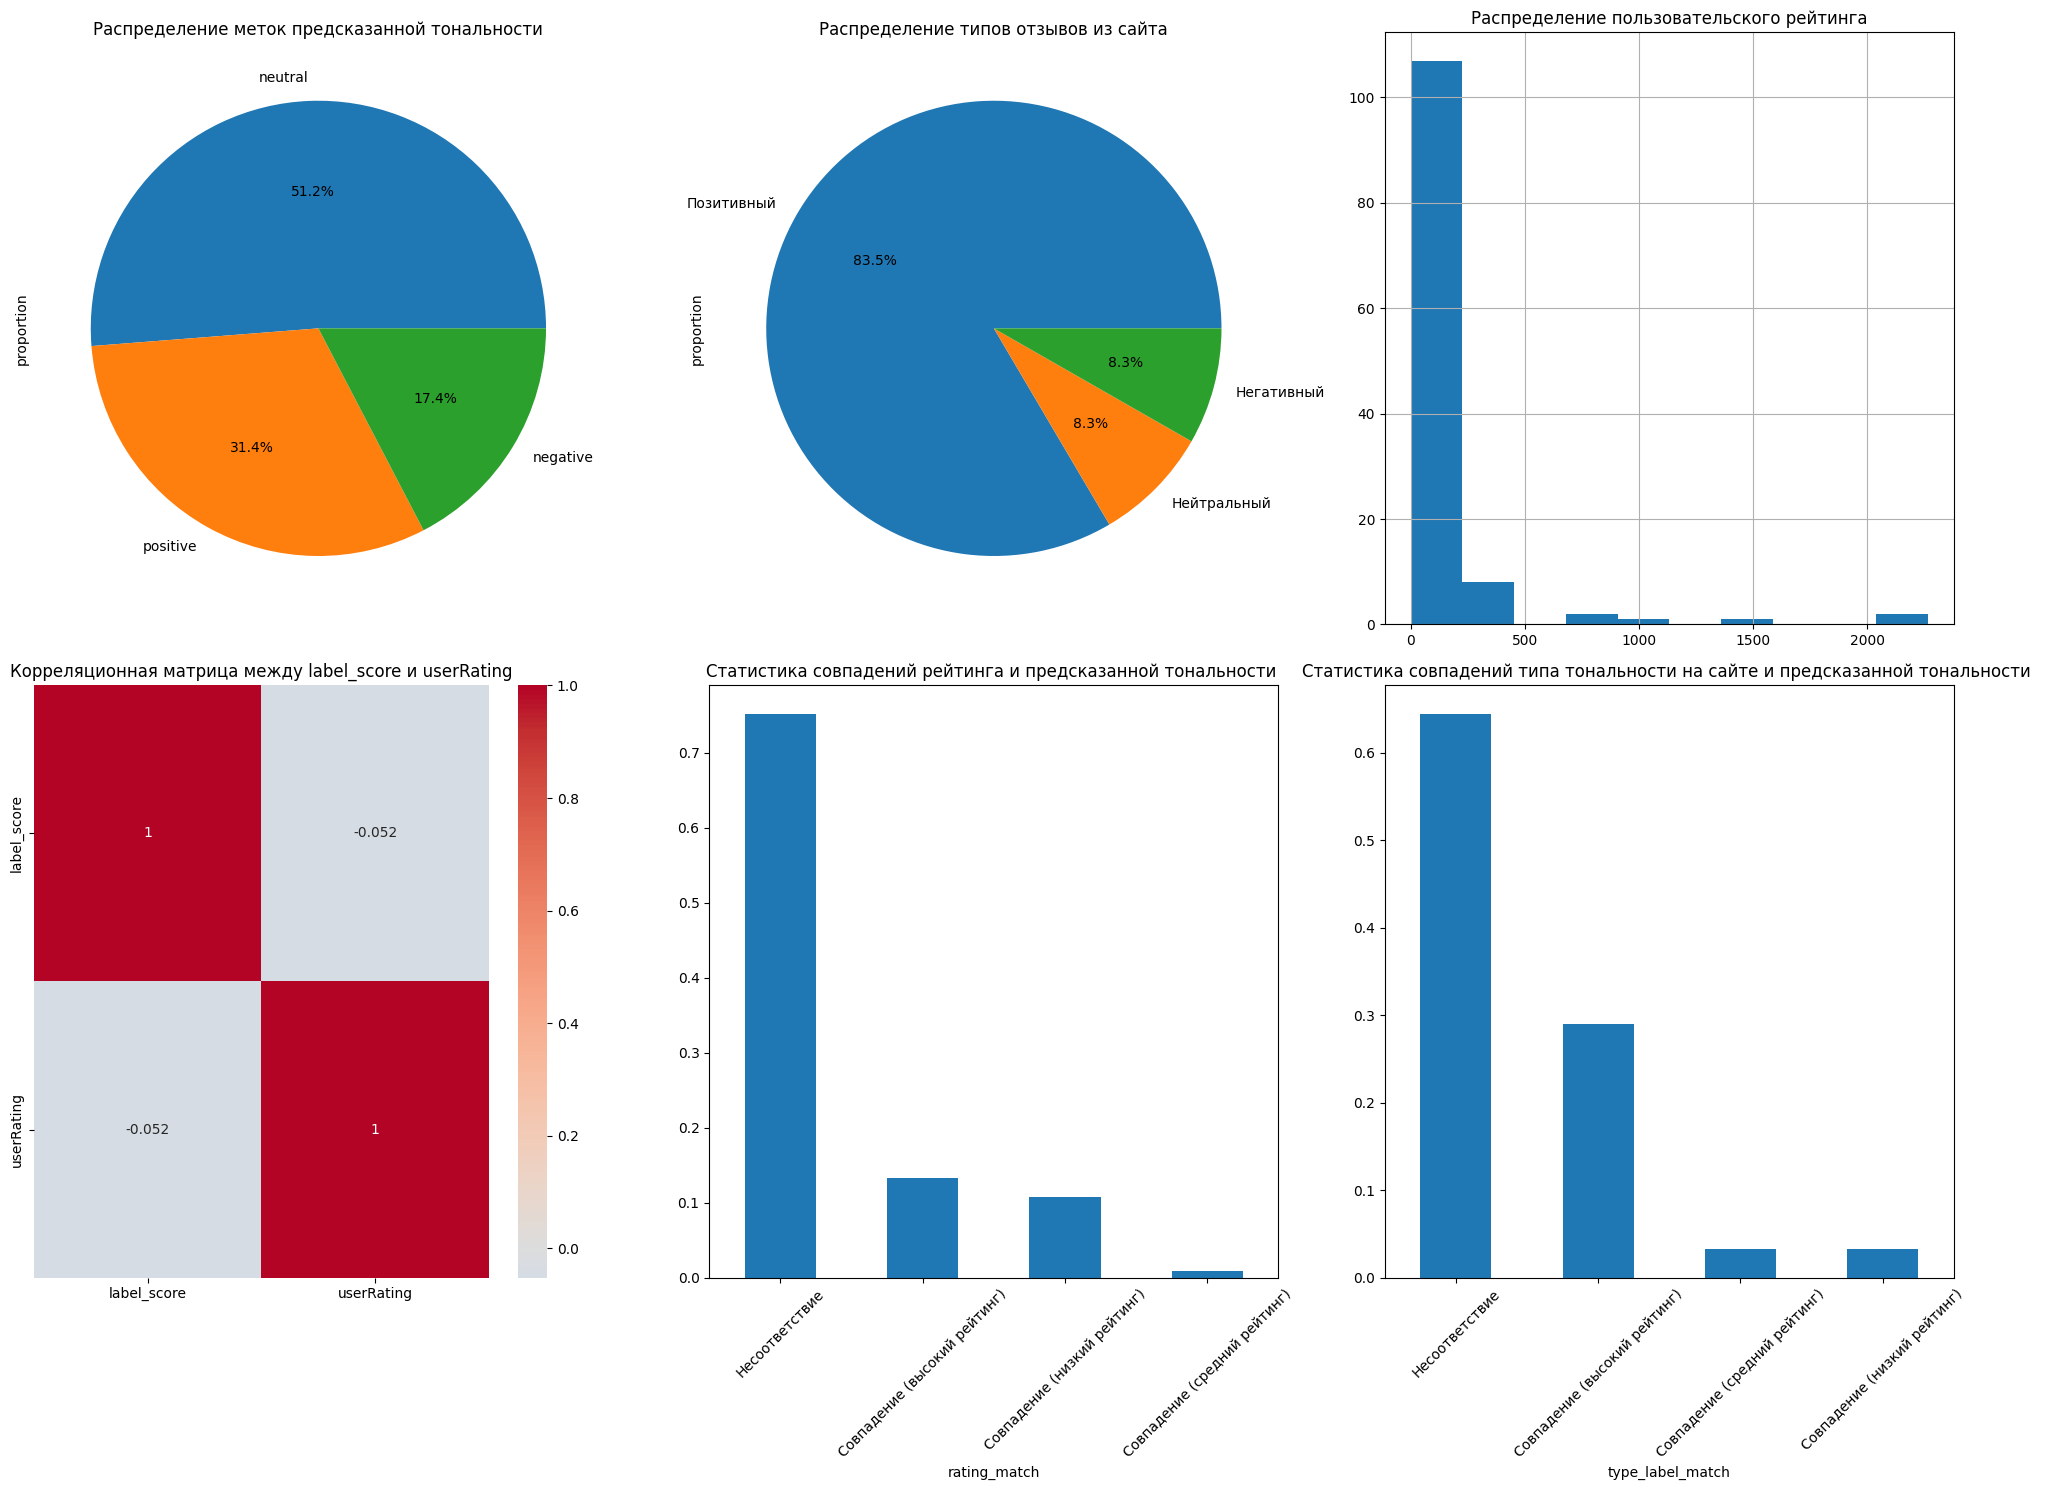

Распределение меток предсказанной тональности:
label
neutral     0.512397
positive    0.314050
negative    0.173554
Name: proportion, dtype: float64

Распределение типов отзывов из сайта:
type
Позитивный     0.834711
Нейтральный    0.082645
Негативный     0.082645
Name: proportion, dtype: float64
\Распределение рейтинга:
count     121.000000
mean      115.669421
std       343.173969
min         0.000000
25%         0.000000
50%         2.000000
75%        71.000000
max      2265.000000
Name: userRating, dtype: float64

Корреляция label_score и userRating: -0.05

Статистика совпадений рейтинга и предсказанной тональности :
rating_match
Несоответствие                  0.752066
Совпадение (высокий рейтинг)    0.132231
Совпадение (низкий рейтинг)     0.107438
Совпадение (средний рейтинг)    0.008264
Name: proportion, dtype: float64

Статистика совпадений типа тональности на сайте и предсказанной тональности :
type_label_match
Несоответствие                  0.644628
Совпадение (высокий рей

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_results(df):
    # 1. Распределение меток предсказанной тональности
    label_distribution = df['label'].value_counts(normalize=True)

    # 2. Распределение типов отзывов из сайта
    type_distribution = df['type'].value_counts(normalize=True)

    # 3. Распределение рейтинга фильмов
    rating_stats = df['userRating'].describe()

    # 4. Корреляция между label_score и userRating
    correlation =  df[['label_score', 'userRating']].corr()

    # 5. Статистика совпадений рейтинга и предсказанной тональности
    rating_match_distribution = df['rating_match'].value_counts(normalize=True)

    # 6. Статистика совпадений типа тональности на сайте и предсказанной тональности
    type_label_match_distribution = df['type_label_match'].value_counts(normalize=True)

    # Визуализация
    plt.figure(figsize=(20,15))

    # График 1: Распределение меток предсказанной тональности
    plt.subplot(2,3,1)
    label_distribution.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Распределение меток предсказанной тональности')

    # График 2: Распределение типов отзывов из сайта
    plt.subplot(2,3,2)
    type_distribution.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Распределение типов отзывов из сайта')

    # График 3: Распределение рейтинга фильмов
    plt.subplot(2,3,3)
    df['userRating'].hist(bins=10)
    plt.title('Распределение пользовательского рейтинга')

    # График 4. Корреляция между label_score и userRating
    plt.subplot(2,3,4)
    sns.heatmap(correlation,
            annot=True,  # показывать значения
            cmap='coolwarm',
            center=0)
    plt.title('Корреляционная матрица между label_score и userRating')

    # График 5: Статистика совпадений рейтинга и предсказанной тональности
    plt.subplot(2,3,5)
    rating_match_distribution.plot(kind='bar')
    plt.title('Статистика совпадений рейтинга и предсказанной тональности ')
    plt.xticks(rotation=45)

    # График 6: Статистика совпадений типа тональности на сайте и предсказанной тональности
    plt.subplot(2,3,6)
    type_label_match_distribution.plot(kind='bar')
    plt.title('Статистика совпадений типа тональности на сайте и предсказанной тональности ')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Вывод статистики
    print("Распределение меток предсказанной тональности:")
    print(label_distribution)

    print("\nРаспределение типов отзывов из сайта:")
    print(type_distribution)

    print("\Распределение рейтинга:")
    print(rating_stats)

    print(f"\nКорреляция label_score и userRating: {(df['label_score'].corr(df['userRating'])):.2f}")

    print("\nСтатистика совпадений рейтинга и предсказанной тональности :")
    print(rating_match_distribution)

    print("\nСтатистика совпадений типа тональности на сайте и предсказанной тональности :")
    print(type_label_match_distribution)

# Выполнение анализа
analyze_results(df)

Рейтинг и предсказанная тональность могут не совпадать из-за того, что было отобрано всего по 11 отзывов для каждого фильма, среди которых могло быть неравное распределение, несоответствующее реальности изза маленького количества